# Index

In [1]:
from data import *
from train_2 import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)
print(df_domain_transfer_learning_train.shape)
print(df_domain_transfer_learning_test.shape)

(4251, 3)
(373, 3)
(70, 3)
(30, 3)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_transfer_learning_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_transfer_learning_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.842857142857143
rain:0.4024285714285715
Tª:70.44571428571427
TEST:
age:9.933333333333334
rain:0.3903333333333334
Tª:69.72333333333333


In [5]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

# Linear regression transfer_learning subset (domain-microbiome)

### Get numpy transfer_learning objects

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    #for s in layers_list:
    #    net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [7]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None)
              #layers_list=[128,256],
              #activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [8]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 4.7702 (min: 4.6950, max: 4.9490)

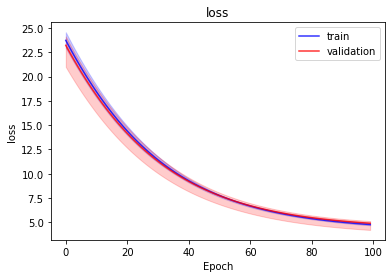

<b>domain_BrayCurtis</b>: 0.5486 (min: 0.5199, max: 0.6107)

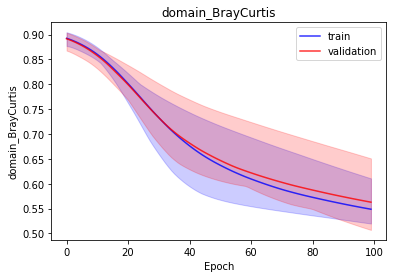

<b>domain_pearson_corr</b>: 0.5625 (min: 0.3762, max: 0.6441)

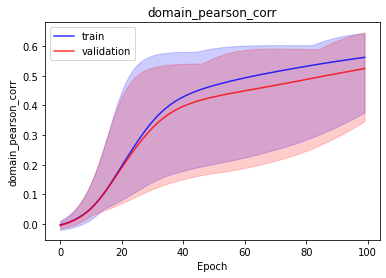

<b>domain_jensen_shannon_divergence</b>: 1.3860 (min: 1.2468, max: 1.5582)

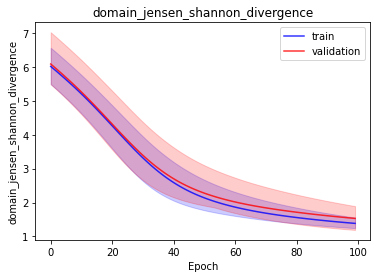

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 4.770208740234375 | 4.695002555847168 | 4.94900369644165 |
| domain_BrayCurtis | 0.5486301183700562 | 0.5198960900306702 | 0.6106730103492737 |
| domain_pearson_corr | 0.5625126361846924 | 0.37617143988609314 | 0.6440922617912292 |
| domain_jensen_shannon_divergence | 1.385970115661621 | 1.2467750310897827 | 1.5582449436187744 |


[('best_lost_epoch', 99),
 ('val_loss', [4.903912925720215, 4.217108249664307, 5.12975549697876]),
 ('val_domain_BrayCurtis', [0.56281394, 0.50699776, 0.65086883]),
 ('val_domain_pearson_corr', [0.5246717, 0.34741136, 0.64726174]),
 ('val_domain_jensen_shannon_divergence', [1.5323642, 1.1935295, 1.8952221])]

In [9]:
print_results(results)

In [10]:
def test_model(models, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(domain_transfer_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(bioma_transfer_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

#     md_text ="### Best Otus\n"
#     md_text += "| OTU | mse |\n"
#     md_text += "|:----|----:|\n"
#     for v, k in mse_otus_keys[:10]:
#         md_text += "| {} | {} |\n".format(k, v)
#     md_text += "\n\n"
#     md_text +="### Worst Otus\n"
#     md_text += "| OTU | mse |\n"
#     md_text += "|:----|----:|\n"
#     for v, k in reversed(mse_otus_keys[-10:]):
#         md_text += "| {} | {} |\n".format(k, v)

#     display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [11]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.5595712661743164 | 0.5312227606773376 | 0.6340692043304443 |
| pearson_corr | 0.5435569882392883 | 0.3510879874229431 | 0.6382132172584534 |
| jensen_shannon_divergence | 1.6071207523345947 | 1.3902374505996704 | 1.7915074825286865 |


# MLP (Dense) transfer_learning subset (domain-microbiome)

In [12]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [13]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [14]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>93</b></p>

<b>loss</b>: 3.7853 (min: 3.6893, max: 3.9831)

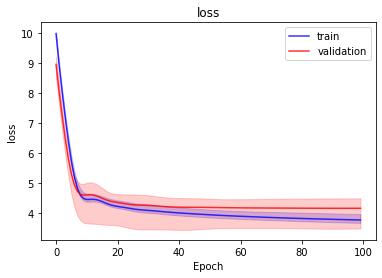

<b>domain_BrayCurtis</b>: 0.4397 (min: 0.4348, max: 0.4469)

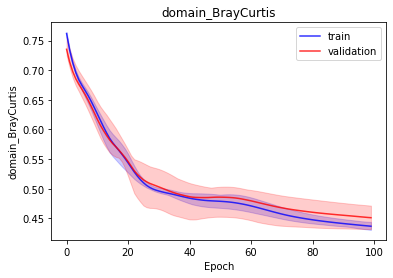

<b>domain_pearson_corr</b>: 0.7027 (min: 0.6913, max: 0.7141)

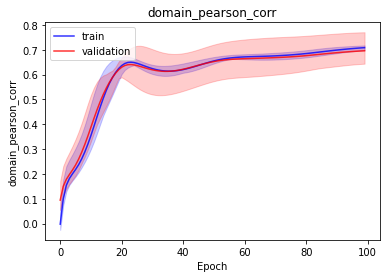

<b>domain_jensen_shannon_divergence</b>: 0.8619 (min: 0.8382, max: 0.8983)

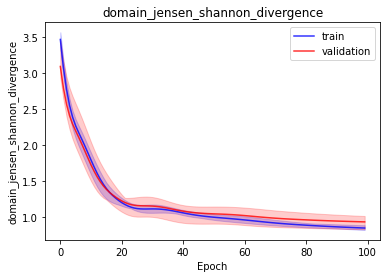

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7853016376495363 | 3.6893293857574463 | 3.983119249343872 |
| domain_BrayCurtis | 0.43974167108535767 | 0.43478304147720337 | 0.44694045186042786 |
| domain_pearson_corr | 0.7027307748794556 | 0.6913072466850281 | 0.7140693664550781 |
| domain_jensen_shannon_divergence | 0.861868679523468 | 0.8382407426834106 | 0.8983267545700073 |


[('best_lost_epoch', 93),
 ('val_loss', [4.160576629638672, 3.481121063232422, 4.489664554595947]),
 ('val_domain_BrayCurtis', [0.45389065, 0.4326654, 0.47431317]),
 ('val_domain_pearson_corr', [0.69140077, 0.6380426, 0.76785403]),
 ('val_domain_jensen_shannon_divergence', [0.944133, 0.83957034, 1.0304328])]

In [15]:
print_results(results)

In [16]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.44770389795303345 | 0.4419330060482025 | 0.45534414052963257 |
| pearson_corr | 0.6923134922981262 | 0.6727209091186523 | 0.7073325514793396 |
| jensen_shannon_divergence | 1.073110818862915 | 1.0597383975982666 | 1.1046863794326782 |


In [17]:
predictions

array([[1.62510230e-04, 5.65533765e-06, 3.21839447e-03, ...,
        3.72465001e-06, 1.49083734e-02, 6.25485991e-05],
       [1.86829071e-04, 6.10747884e-06, 2.01639207e-03, ...,
        4.50483958e-06, 2.88393684e-02, 4.80289709e-05],
       [1.93580898e-04, 5.65734535e-06, 4.86820383e-04, ...,
        5.63301819e-06, 8.89243633e-02, 2.35950229e-05],
       ...,
       [1.05739884e-04, 6.82189875e-06, 3.71388567e-04, ...,
        4.99853968e-06, 8.22849497e-02, 6.64967820e-06],
       [1.93580898e-04, 5.65734535e-06, 4.86820383e-04, ...,
        5.63301819e-06, 8.89243633e-02, 2.35950229e-05],
       [1.97011046e-04, 6.41030056e-06, 1.24490471e-03, ...,
        5.28425608e-06, 4.80746105e-02, 3.94144336e-05]], dtype=float32)

# Autoencoder transfer_learning subset (domain-microbiome)

### Get numpy train objects

In [18]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [19]:
data_domain_train.shape[1]

3

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>86</b></p>

<b>loss</b>: 0.6231 (min: 0.6231, max: 0.6231)

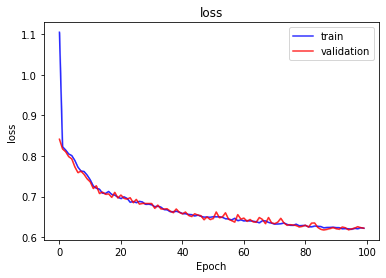

<b>bioma_loss</b>: 0.1954 (min: 0.1954, max: 0.1954)

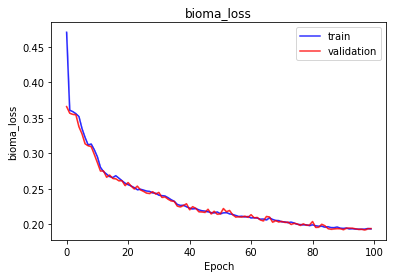

<b>domain_loss</b>: 0.4086 (min: 0.4086, max: 0.4086)

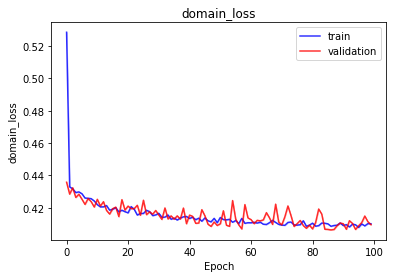

<b>latent_loss</b>: 0.0191 (min: 0.0191, max: 0.0191)

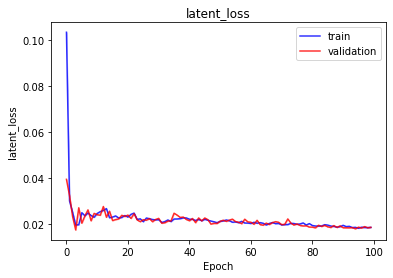

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

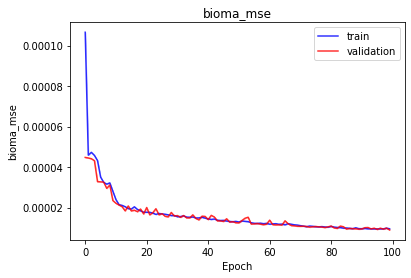

<b>bioma_mae</b>: 0.0005 (min: 0.0005, max: 0.0005)

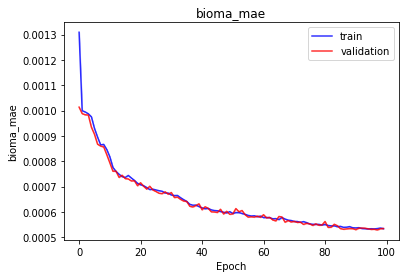

<b>bioma_mape</b>: 4840.4062 (min: 4840.4062, max: 4840.4062)

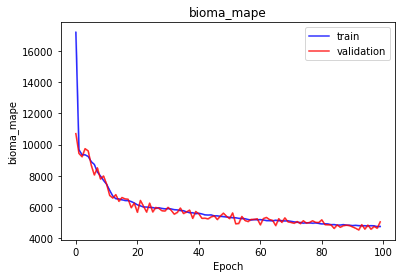

<b>bioma_BrayCurtis</b>: 0.1954 (min: 0.1954, max: 0.1954)

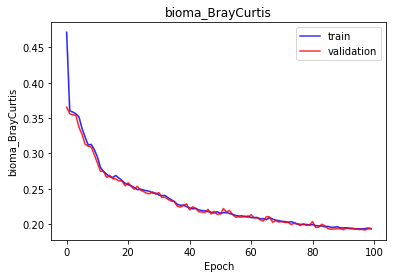

<b>bioma_pearson_corr</b>: 0.9274 (min: 0.9274, max: 0.9274)

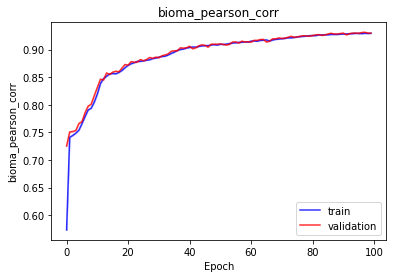

<b>bioma_jensen_shannon_divergence</b>: 0.3339 (min: 0.3339, max: 0.3339)

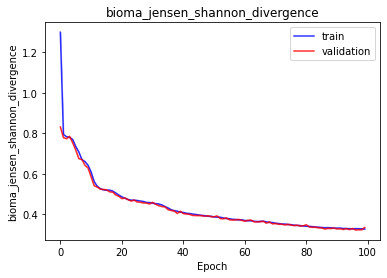

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

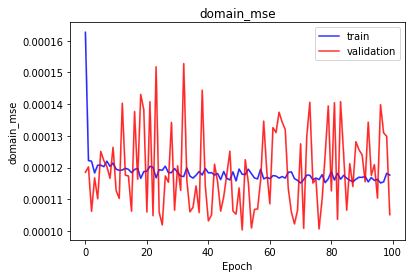

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

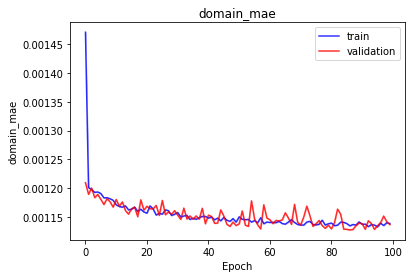

<b>domain_mape</b>: 8087.5776 (min: 8087.5776, max: 8087.5776)

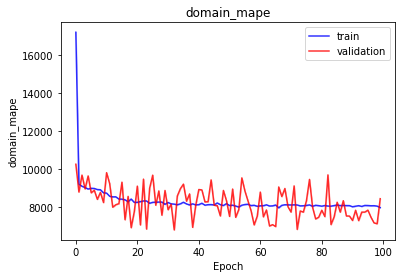

<b>domain_BrayCurtis</b>: 0.4086 (min: 0.4086, max: 0.4086)

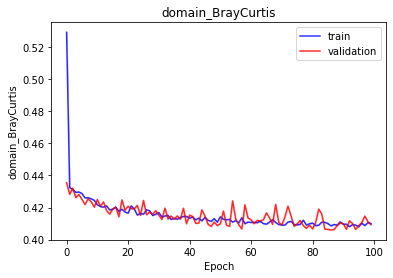

<b>domain_pearson_corr</b>: 0.7265 (min: 0.7265, max: 0.7265)

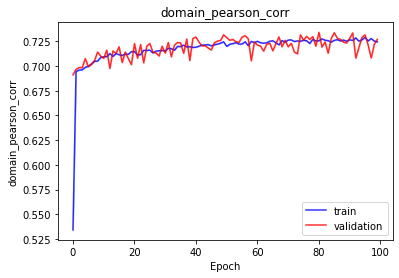

<b>domain_jensen_shannon_divergence</b>: 0.8983 (min: 0.8983, max: 0.8983)

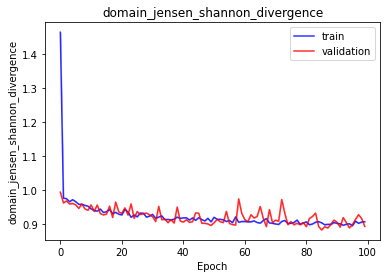

<b>latent_mae</b>: 0.0191 (min: 0.0191, max: 0.0191)

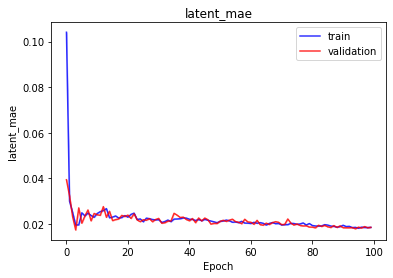

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6230566699177875 | 0.6230566699177875 | 0.6230566699177875 |
| bioma_loss | 0.1954420804977417 | 0.1954420804977417 | 0.1954420804977417 |
| domain_loss | 0.40855643153190613 | 0.40855643153190613 | 0.40855643153190613 |
| latent_loss | 0.019068285822868347 | 0.019068285822868347 | 0.019068285822868347 |
| bioma_mse | 9.783483619685285e-06 | 9.783483619685285e-06 | 9.783483619685285e-06 |
| bioma_mae | 0.0005393112078309059 | 0.0005393112078309059 | 0.0005393112078309059 |
| bioma_mape | 4840.40625 | 4840.40625 | 4840.40625 |
| bioma_BrayCurtis | 0.19538778066635132 | 0.19538778066635132 | 0.19538778066635132 |
| bioma_pearson_corr | 0.9274447560310364 | 0.9274447560310364 | 0.9274447560310364 |
| bioma_jensen_shannon_divergence | 0.3338826894760132 | 0.3338826894760132 | 0.3338826894760132 |
| domain_mse | 0.00011603492748690769 | 0.00011603492748690769 | 0.00011603492748690769 |
| domain_mae | 0.0011342684738337994 | 0.0011342684738337994 | 0.0011342684738337994 |
| domain_mape | 8087.57763671875 | 8087.57763671875 | 8087.57763671875 |
| domain_BrayCurtis | 0.4086041748523712 | 0.4086041748523712 | 0.4086041748523712 |
| domain_pearson_corr | 0.7265234589576721 | 0.7265234589576721 | 0.7265234589576721 |
| domain_jensen_shannon_divergence | 0.8983076810836792 | 0.8983076810836792 | 0.8983076810836792 |
| latent_mae | 0.019064750522375107 | 0.019064750522375107 | 0.019064750522375107 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

In [22]:
data_domain_train

array([[1.10e+01, 7.62e+01, 2.10e-01],
       [1.00e+01, 6.95e+01, 1.20e-01],
       [8.00e+00, 7.32e+01, 9.00e-02],
       ...,
       [7.00e+00, 8.00e+01, 0.00e+00],
       [4.00e+00, 6.48e+01, 4.00e-01],
       [1.50e+01, 7.45e+01, 1.00e-02]], dtype=float32)

### To get encoders and decoders to use in transfer learning model

In [23]:
models[0]

(<tensorflow.python.keras.engine.training.Model at 0x7f8f184cce48>,
 <tensorflow.python.keras.engine.training.Model at 0x7f8f1852acf8>)

In [24]:
model, encoder, encoder_domain, decoder = models[0]

### To predict latent space for samples in transfer learning Walters et al. subset

In [25]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neuronas latent space (activation function output=activation_latent='tanh')

In [26]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [27]:
def train_tl_noEnsemble(model_fn,
          data_latent_train,
          data_latent_val,
          data_domain_train,
          data_domain_val,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    y_train, y_val = data_latent_train, data_latent_val
    x_train, x_val = data_domain_train, data_domain_val
    model = model_fn()
    metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    return r, model

In [28]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [29]:
model_tl

In [30]:
def test_model_tl_latent(model, latent_transfer_test, domain_transfer_test):

    metrics_results = {}

    final_predictions = model.predict(domain_transfer_test)
    
    result = se = tf.math.squared_difference(final_predictions, latent_transfer_test)
    metrics_results['mse'] =result.numpy()

    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
       md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])
    
    display(Markdown(md_text))
    
    return final_predictions

In [31]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0006882011657580733 | 2.5665997327450896e-08 | 0.014170664362609386 |


## Domain -> latent -> microbiome. Test set transfer_learning
### Only 1 latent space

In [32]:
def test_model_tl_noEnsemble(model, decoder, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    final_predictions = model.predict(domain_transfer_test)
    
    final_decoded = decoder.predict(final_predictions)
    
    predictions = tf.nn.softmax(final_decoded)
    
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(bioma_transfer_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])

    display(Markdown(md_text))
    
    return predictions

### a) With model_TL

In [33]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.43219661712646484 | 0.43219661712646484 | 0.43219661712646484 |
| pearson_corr | 0.7122396230697632 | 0.7122396230697632 | 0.7122396230697632 |
| jensen_shannon_divergence | 1.0648300647735596 | 1.0648300647735596 | 1.0648300647735596 |


### b) With the encoder_domain (best case)

In [34]:
# Test with encoder_biome, en vez de model_tl
predictions = test_model_tl_noEnsemble(encoder_domain, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.39380231499671936 | 0.39380231499671936 | 0.39380231499671936 |
| pearson_corr | 0.7655762434005737 | 0.7655762434005737 | 0.7655762434005737 |
| jensen_shannon_divergence | 0.9139352440834045 | 0.9139352440834045 | 0.9139352440834045 |


# To create auto-encoder combined model - 5 domain variables

In [35]:
from train import *

### Get datasets with 5 variables and numpy train objects

In [36]:
#df_microbioma_train, df_microbioma_test, \
#df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
#df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
#otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [37]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [38]:
data_domain_train.shape[1]

36

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.6281 (min: 0.6281, max: 0.6281)

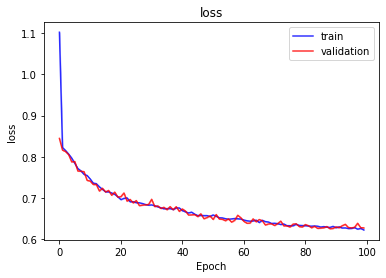

<b>bioma_loss</b>: 0.2035 (min: 0.2035, max: 0.2035)

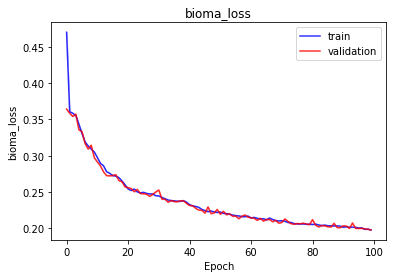

<b>domain_loss</b>: 0.4066 (min: 0.4066, max: 0.4066)

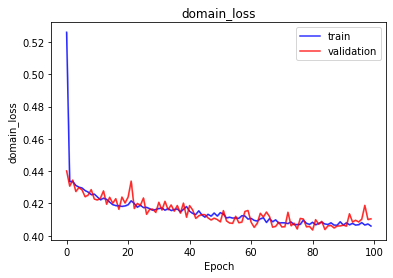

<b>latent_loss</b>: 0.0181 (min: 0.0181, max: 0.0181)

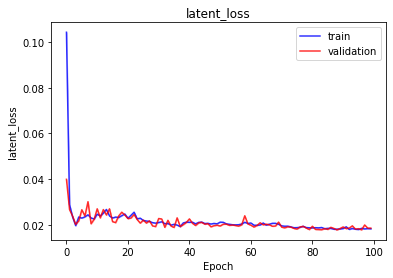

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

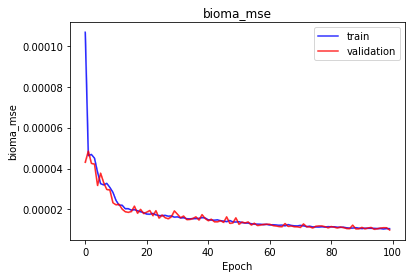

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

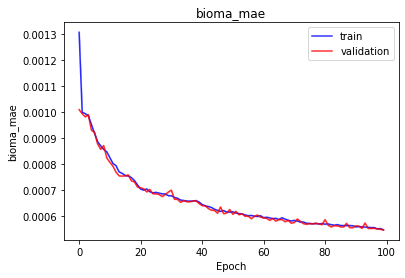

<b>bioma_mape</b>: 4990.9136 (min: 4990.9136, max: 4990.9136)

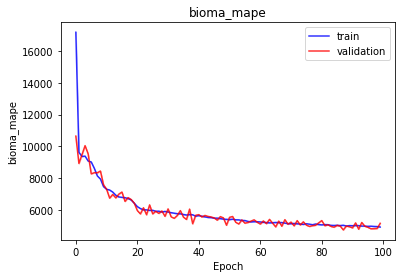

<b>bioma_BrayCurtis</b>: 0.2037 (min: 0.2037, max: 0.2037)

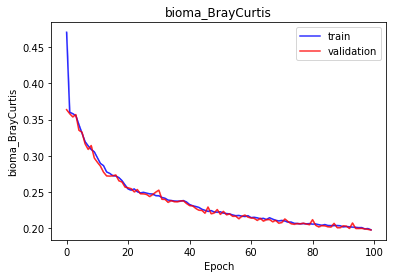

<b>bioma_pearson_corr</b>: 0.9189 (min: 0.9189, max: 0.9189)

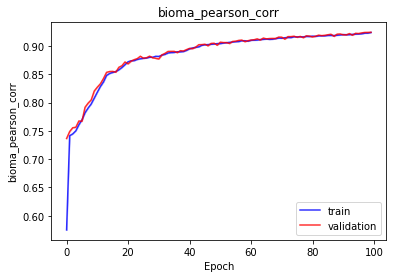

<b>bioma_jensen_shannon_divergence</b>: 0.3575 (min: 0.3575, max: 0.3575)

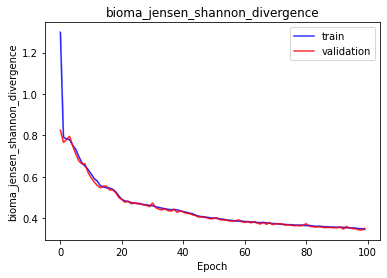

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

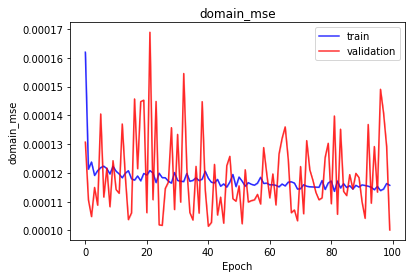

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

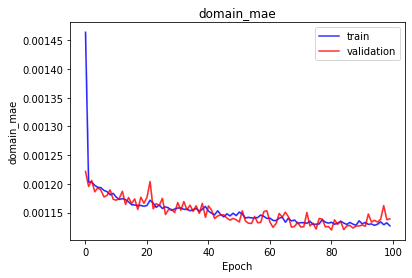

<b>domain_mape</b>: 8071.3364 (min: 8071.3364, max: 8071.3364)

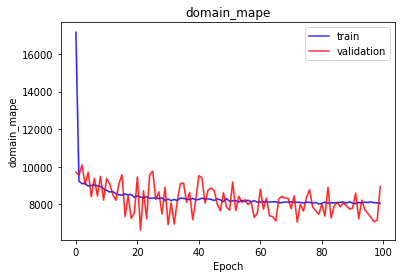

<b>domain_BrayCurtis</b>: 0.4063 (min: 0.4063, max: 0.4063)

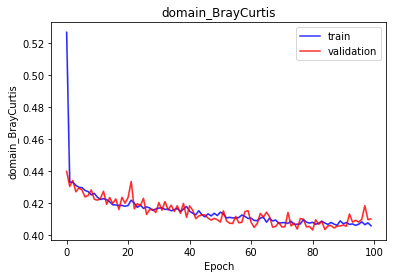

<b>domain_pearson_corr</b>: 0.7299 (min: 0.7299, max: 0.7299)

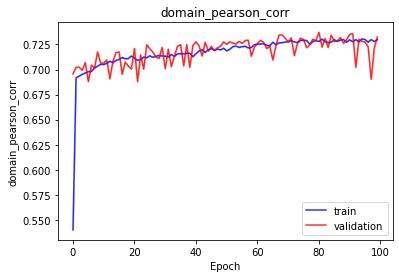

<b>domain_jensen_shannon_divergence</b>: 0.8937 (min: 0.8937, max: 0.8937)

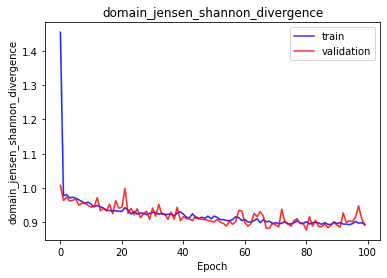

<b>latent_mae</b>: 0.0181 (min: 0.0181, max: 0.0181)

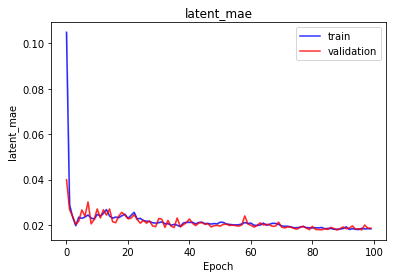

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6281308365468277 | 0.6281308365468277 | 0.6281308365468277 |
| bioma_loss | 0.20353731513023376 | 0.20353731513023376 | 0.20353731513023376 |
| domain_loss | 0.40655675530433655 | 0.40655675530433655 | 0.40655675530433655 |
| latent_loss | 0.018124405294656754 | 0.018124405294656754 | 0.018124405294656754 |
| bioma_mse | 1.11272174763144e-05 | 1.11272174763144e-05 | 1.11272174763144e-05 |
| bioma_mae | 0.0005624765763059258 | 0.0005624765763059258 | 0.0005624765763059258 |
| bioma_mape | 4990.91357421875 | 4990.91357421875 | 4990.91357421875 |
| bioma_BrayCurtis | 0.2036895602941513 | 0.2036895602941513 | 0.2036895602941513 |
| bioma_pearson_corr | 0.918918788433075 | 0.918918788433075 | 0.918918788433075 |
| bioma_jensen_shannon_divergence | 0.3575323224067688 | 0.3575323224067688 | 0.3575323224067688 |
| domain_mse | 0.00011569513299036771 | 0.00011569513299036771 | 0.00011569513299036771 |
| domain_mae | 0.0011279369937255979 | 0.0011279369937255979 | 0.0011279369937255979 |
| domain_mape | 8071.33642578125 | 8071.33642578125 | 8071.33642578125 |
| domain_BrayCurtis | 0.40633508563041687 | 0.40633508563041687 | 0.40633508563041687 |
| domain_pearson_corr | 0.7299425005912781 | 0.7299425005912781 | 0.7299425005912781 |
| domain_jensen_shannon_divergence | 0.8937239050865173 | 0.8937239050865173 | 0.8937239050865173 |
| latent_mae | 0.018106121569871902 | 0.018106121569871902 | 0.018106121569871902 |


*************

In [39]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh',
                        show_results=True, 
                        device='/CPU:0')

In [40]:
data_domain_train.shape

(4251, 36)

### To get encoders and decoders to use in transfer learning model

In [41]:
models[0]

(<tensorflow.python.keras.engine.training.Model at 0x7f8ef2335be0>,
 <tensorflow.python.keras.engine.training.Model at 0x7f8ef2311a90>)

In [42]:
model, encoder, encoder_domain, decoder = models[0]

### To recover data with 3 domain features

In [43]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [44]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in transfer learning Walters et al. subset

In [45]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neuronas latent space (activation function output=activation_latent='tanh')

In [46]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [47]:
def train_tl_noEnsemble(model_fn,
          data_latent_train,
          data_latent_val,
          data_domain_train,
          data_domain_val,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    y_train, y_val = data_latent_train, data_latent_val
    x_train, x_val = data_domain_train, data_domain_val
    model = model_fn()
    metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    return r, model

In [48]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [49]:
model_tl

In [50]:
def test_model_tl_latent(model, latent_transfer_test, domain_transfer_test):

    metrics_results = {}

    final_predictions = model.predict(domain_transfer_test)
    
    result = se = tf.math.squared_difference(final_predictions, latent_transfer_test)
    metrics_results['mse'] =result.numpy()

    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
       md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])
    
    display(Markdown(md_text))
    
    return predictions

In [51]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.000678703305311501 | 2.1802164518192058e-09 | 0.013881624676287174 |


## Domain -> latent -> microbiome. Test set transfer_learning
### Only 1 latent space

In [52]:
def test_model_tl_noEnsemble(model, decoder, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    final_predictions = model.predict(domain_transfer_test)
    
    final_decoded = decoder.predict(final_predictions)
    
    predictions = tf.nn.softmax(final_decoded)
    
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(bioma_transfer_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])

    display(Markdown(md_text))
    
    return predictions

### a) With model_TL

In [53]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4345511198043823 | 0.4345511198043823 | 0.4345511198043823 |
| pearson_corr | 0.726608395576477 | 0.726608395576477 | 0.726608395576477 |
| jensen_shannon_divergence | 1.032882809638977 | 1.032882809638977 | 1.032882809638977 |


### b) With the encoder_domain (best case)

In [54]:
# Test with encoder_biome, en vez de model_tl
#predictions = test_model_tl_noEnsemble(encoder_domain, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
# --> Encoder with 5 variables couldn't predict with only 3 variables as input!!

--> Encoder with 5 variables couldn't predict with only 3 variables as input!!

# To create auto-encoder OTU latent space

In [55]:
from train import *

### Get datasets with 5 variables and numpy train objects

In [56]:
#df_microbioma_train, df_microbioma_test, \
#df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
#df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
#otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [57]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [58]:
data_domain_train.shape[1]

36

In [59]:
def model(shape, input_transform, output_transform, layers_list, latent_space, activation_fn):
    return autoencoder(domain_shape=None, 
                       bioma_layers=layers_list, 
                       latent_space=latent_space,
                       input_transform=input_transform,
                       output_transform=output_transform,
                       activation_function_encoder=activation_fn,
                       activation_function_decoder=activation_fn,
                       activation_function_latent=activation_fn)

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [60]:
latent_space = 100
def model_fn():
    m, e, _, d = model(shape=717,
                      input_transform=CenterLogRatio(),
                      output_transform=None,
                      layers_list=[256,128],
                      latent_space=latent_space,
                      activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, e, None, d

In [61]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=0,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>97</b></p>

<b>loss</b>: 1.8204 (min: 1.8204, max: 1.8204)

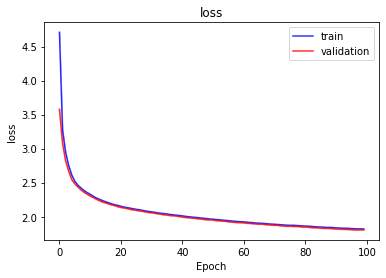

<b>bioma_BrayCurtis</b>: 0.2398 (min: 0.2398, max: 0.2398)

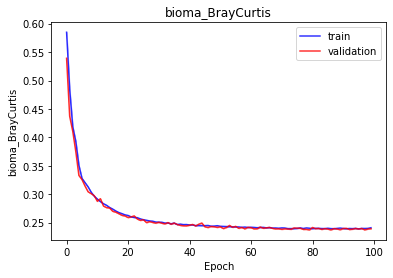

<b>bioma_pearson_corr</b>: 0.8786 (min: 0.8786, max: 0.8786)

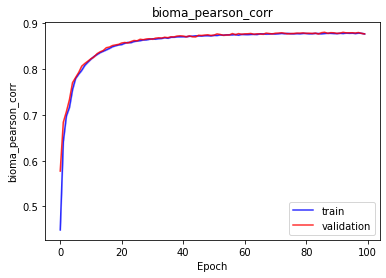

<b>bioma_jensen_shannon_divergence</b>: 0.3161 (min: 0.3161, max: 0.3161)

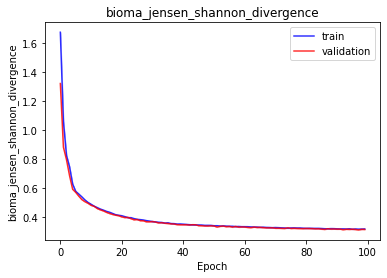

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.8204195906318965 | 1.8204195906318965 | 1.8204195906318965 |
| bioma_BrayCurtis | 0.2397574633359909 | 0.2397574633359909 | 0.2397574633359909 |
| bioma_pearson_corr | 0.8785807490348816 | 0.8785807490348816 | 0.8785807490348816 |
| bioma_jensen_shannon_divergence | 0.31613844633102417 | 0.31613844633102417 | 0.31613844633102417 |


[('best_lost_epoch', 97),
 ('val_loss', [1.8053341481223035, 1.8053341481223035, 1.8053341481223035]),
 ('val_bioma_BrayCurtis', [0.23730636, 0.23730636, 0.23730636]),
 ('val_bioma_pearson_corr', [0.87973446, 0.87973446, 0.87973446]),
 ('val_bioma_jensen_shannon_divergence', [0.31058168, 0.31058168, 0.31058168])]

In [62]:
print_results(results)

In [63]:
#predictions = test_model(models, CenterLogRatio, None)
#save_predictions(predictions, 'experiment_autoencoder_bioma.txt')

In [64]:
######################

In [65]:
data_domain_train.shape

(4251, 36)

### To get encoders and decoders to use in transfer learning model

In [66]:
models[0]

(<tensorflow.python.keras.engine.training.Model at 0x7f8ef11bacf8>,
 None,
 <tensorflow.python.keras.engine.training.Model at 0x7f8ef1011f60>)

In [67]:
model, encoder, _ ,decoder = models[0]

### To recover data with 3 domain features

In [68]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [69]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in transfer learning Walters et al. subset

In [70]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neuronas latent space (activation function output=activation_latent='tanh')

In [71]:
def model_fn_tl():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [72]:
def train_tl_noEnsemble(model_fn,
          data_latent_train,
          data_latent_val,
          data_domain_train,
          data_domain_val,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    y_train, y_val = data_latent_train, data_latent_val
    x_train, x_val = data_domain_train, data_domain_val
    model = model_fn()
    metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    return r, model

In [73]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [74]:
model_tl

In [75]:
def test_model_tl_latent(model, latent_transfer_test, domain_transfer_test):

    metrics_results = {}

    final_predictions = model.predict(domain_transfer_test)
    
    result = se = tf.math.squared_difference(final_predictions, latent_transfer_test)
    metrics_results['mse'] =result.numpy()

    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
       md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])
    
    display(Markdown(md_text))
    
    return predictions

In [76]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.30218812823295593 | 1.68839164871315e-10 | 3.5883448123931885 |


## Domain -> latent -> microbiome. Test set transfer_learning
### Only 1 latent space

In [77]:
def test_model_tl_noEnsemble(model, decoder, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    final_predictions = model.predict(domain_transfer_test)
    
    final_decoded = decoder.predict(final_predictions)
    
    predictions = tf.nn.softmax(final_decoded)
    
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(bioma_transfer_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])

    display(Markdown(md_text))
    
    return predictions

### a) With model_TL

In [78]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.9990530014038086 | 0.9990530014038086 | 0.9990530014038086 |
| pearson_corr | 0.27170416712760925 | 0.27170416712760925 | 0.27170416712760925 |
| jensen_shannon_divergence | nan | nan | nan |
